# Convolutional Variational Autoencoder (CNN-VAE)

In [14]:
import sys
import os
from os.path import join
parent_dir = os.path.abspath(join(os.getcwd(), os.pardir))
app_dir = join(parent_dir, "app")
if app_dir not in sys.path:
      sys.path.append(app_dir)

from pathlib import Path
import torch as pt
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from CNN_VAE import ConvDecoder, ConvEncoder, Autoencoder
from utils.training_loop import train_cnn_vae
import utils.config as config
from sklearn import metrics
import matplotlib.pyplot as plt

pt.manual_seed(0)

plt.rcParams["figure.dpi"] = 180

# use GPU if possible
device = pt.device("cuda:0") if pt.cuda.is_available() else pt.device("cpu")
print(device)

DATA_PATH = Path(os.path.abspath('')).parent / "data"
OUTPUT_PATH = Path(os.path.abspath('')).parent / "output" / "VAE"

test_case_name = "new_bsl_more_data"

cpu


#### Initialize Autoencoder and additional parameters

In [15]:
# initialize CNN-VAE classes
encoder = ConvEncoder(
    in_size=config.target_resolution,
    n_channels=config.input_channels,
    n_latent=config.latent_size,
    variational=True,
    layernorm=True
)

decoder = ConvDecoder(
    in_size=config.target_resolution,
    n_channels=config.output_channels,
    n_latent=config.latent_size,
    layernorm=True,
    squash_output=True
)

autoencoder = Autoencoder(encoder, decoder)
autoencoder.to(device)

Autoencoder(
  (_encoder): ConvEncoder(
    (_layers): ModuleList(
      (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): LayerNorm((64, 128, 64), eps=1e-05, elementwise_affine=True)
      (2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
      (3): LayerNorm((128, 64, 32), eps=1e-05, elementwise_affine=True)
      (4): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
      (5): LayerNorm((256, 32, 16), eps=1e-05, elementwise_affine=True)
      (6): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
      (7): LayerNorm((512, 16, 8), eps=1e-05, elementwise_affine=True)
    )
    (_latent_mean): Linear(in_features=65536, out_features=256, bias=True)
    (_latent_log_var): Linear(in_features=65536, out_features=256, bias=True)
  )
  (_decoder): ConvDecoder(
    (_layers): ModuleList(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (1): LayerNorm((256, 32, 16), eps=1e-05, elementwise_affine=True)
      (2): ConvTranspose2d(256, 128, 

#### Load datasets and initialize dataloaders

In [16]:
train_dataset = pt.load(join(DATA_PATH, "train_dataset.pt"))
print("Images in Train Dataset:     ", len(train_dataset))
val_dataset = pt.load(join(DATA_PATH, "val_dataset.pt"))
test_dataset = pt.load(join(DATA_PATH, "test_dataset.pt"))

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)

Images in Train Dataset:      500


#### Initialize training metrics and objects

In [17]:
# optimizer
optimizer = pt.optim.Adam(autoencoder.parameters(), lr=config.learning_rate)

# checkpoint file
checkpoint_file = join(OUTPUT_PATH, "checkpoint_file")

# learning rate scheduler
scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=config.lr_factor)
# mode="min" means that the lr will be reduced when the MSE has stopped decreasing
# factor states by which factor the lr will be reduced on stagnation

test_result = train_cnn_vae(
    model=autoencoder,
    loss_func=nn.MSELoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=config.epochs,
    optimizer=optimizer,
    lr_schedule=scheduler
)

# save the model
autoencoder.save(OUTPUT_PATH)

 Epoch  499/499 - Training loss: 1.235600e-03; Validation loss: 1.583528e-03; Test loss: 6.046170e-03

#### Plot loss over epochs

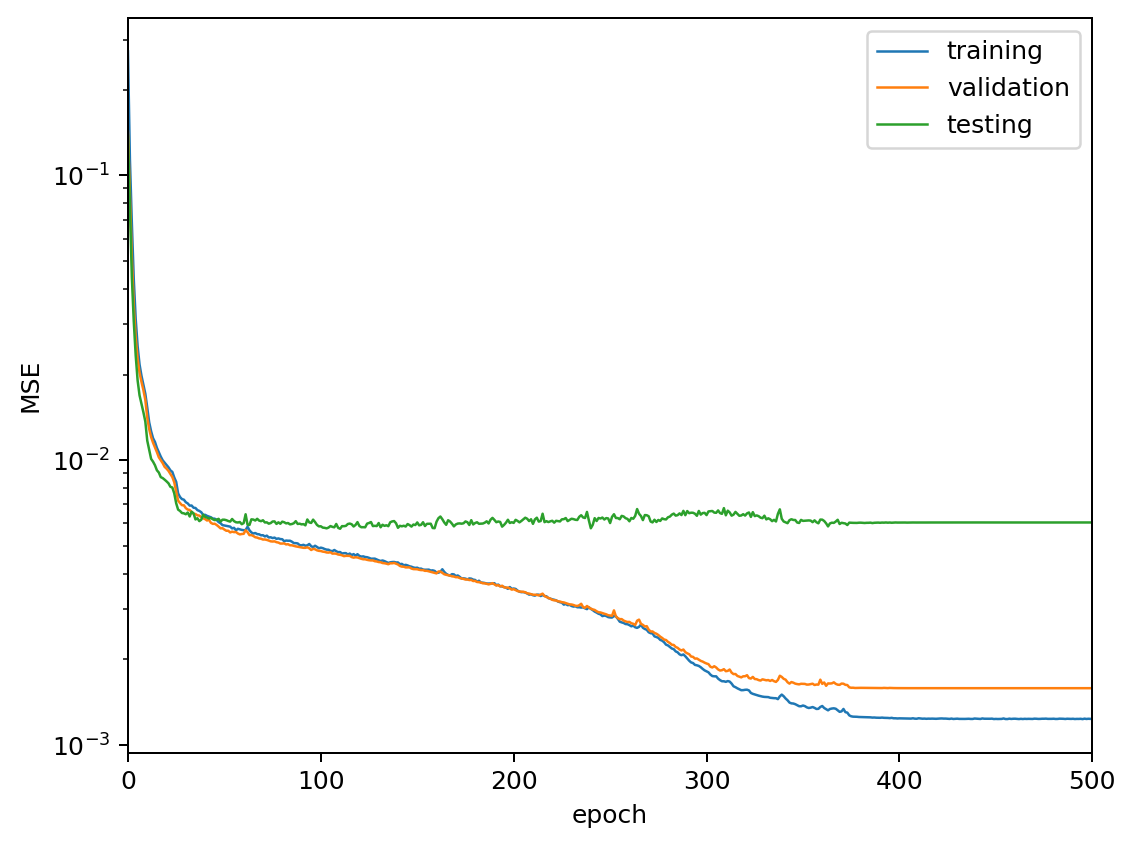

In [18]:
plt.plot(test_result["epoch"], test_result["train_loss"], lw=1, label="training")
plt.plot(test_result["epoch"], test_result["val_loss"], lw=1, label="validation")
plt.plot(test_result["epoch"], test_result["test_loss"], lw=1, label="testing")
plt.yscale("log")
plt.xlim(0, config.epochs)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(join(OUTPUT_PATH, "LOSS_" + test_case_name + ".png"))

#### Make test predictions

In [19]:
# # load model state
# model = pt.nn.Module()
# print(checkpoint_file)
# model.load_state_dict(pt.load(checkpoint_file)["model_state_dict"])

In [20]:
# load coordinates
coords = pt.load(join(DATA_PATH, "coords_interp.pt"))
xx, yy = coords

In [21]:
def make_prediction(model, image):
    with pt.no_grad():
        return model(image.unsqueeze(0)).squeeze(0).squeeze(0).detach()

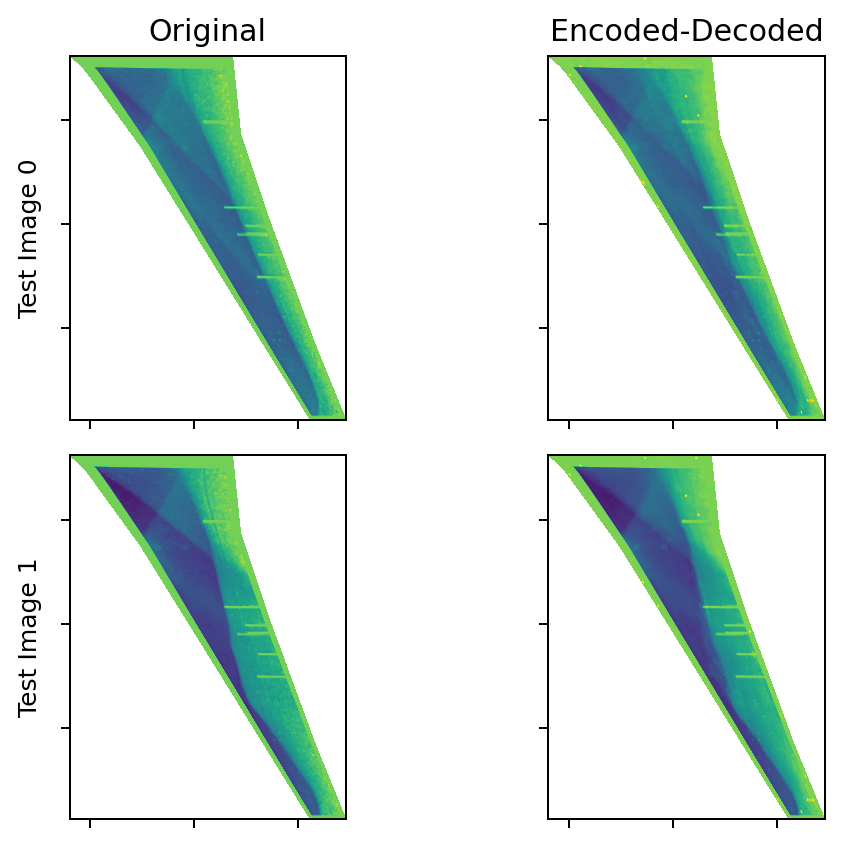

In [22]:
autoencoder.eval()
fig, axes = plt.subplots(2, 2)
vmin, vmax = -1, 1
levels = pt.linspace(vmin, vmax, 120)

for i, row in enumerate(axes):
    if i == 0:
          row[0].set_title("Original")
          row[1].set_title("Encoded-Decoded")

    row[0].contourf(xx, yy, test_dataset[i].squeeze(0), vmin=vmin, vmax=vmax, levels = levels, extend="both")
    row[1].contourf(xx, yy, make_prediction(autoencoder, test_dataset[i]), vmin=vmin, vmax=vmax, levels = levels, extend="both")
    row[0].set_ylabel("Test Image {}".format(i))

    for ax in row:
            ax.set_aspect("equal")
            ax.set_xticklabels([])
            ax.set_yticklabels([])
fig.tight_layout()
plt.savefig(join(OUTPUT_PATH, "RECONSTR_" + test_case_name + ".png"))